# Imports

In [1]:
import os
import pickle
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import normalize
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time  # Optional, to slow down updates a little

# Path Declaration

In [2]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
project_base_path

'/home/ANONYMOUS/projects/FALCON'

In [3]:
saved_v1_generated_data_path = os.path.join(project_base_path, "data/generation/yara/yara-rules_v1.pkl")
saved_v1_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v1.pkl'

In [4]:
saved_v2_generated_data_path = os.path.join(project_base_path, "data/generation/yara/yara-rules_v2.pkl")
saved_v2_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v2.pkl'

# Environment Setup

In [5]:
# ⚙️ Config
RULE_MODEL_NAME = "/data/common/models/sentence-transformers/all-mpnet-base-v2"
CTI_MODEL_NAME = "/data/common/models/sentence-transformers/all-mpnet-base-v2"

BATCH_SIZE = 40
EPOCHS = 10
LR = 2e-5
MAX_LEN = 512
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
###########################
RUN = 1
FINE_TUNED_MODEL_NAME = "all-mpnet-base-v2"
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
        
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/dual-encoder/yara/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")

# Load Dataset

In [6]:
def load_from_pickle(file_path) -> dict:
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [7]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [8]:
# Load the data back from the pickle file
loaded_v1_data = load_from_pickle(saved_v1_generated_data_path)
print(len(loaded_v1_data.keys()))

4588


In [9]:
yara_cti_sample_dict = get_first_n_elements(loaded_v1_data, 10)

In [10]:
# Load the data back from the pickle file
loaded_v2_data = load_from_pickle(saved_v2_generated_data_path)
print(len(loaded_v2_data.keys()))

4587


> Find the common keys in both files.

In [11]:
missing_key = set(loaded_v1_data.keys()) - set(loaded_v2_data.keys())
missing_key = list(missing_key)[0]
missing_key

'rule Install_Shield_2000\n{\n\tmeta:\n\t\tauthor = "PEiD"\n\t\tdescription = "Microsoft Visual C++ 5.0"\n\t\tgroup = "15"\n\t\tfunction = "16"\n\tstrings:\n\t\t$a0 = { 55 8B EC 6A FF 68 ?? ?? ?? ?? 68 ?? ?? ?? ?? 64 A1 ?? ?? ?? ?? 50 64 89 25 ?? ?? ?? ?? 83 C4 ?? 53 56 57 }\n\tcondition:\n\t\t$a0 at pe.entry_point\n}\n\nrule SimbiOZ_Poly_21_Extranger: PEiD\n{\n    strings:\n        $a = { 55 50 8B C4 83 C0 04 C7 00 ?? ?? ?? ?? 58 C3 90 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule PE_Crypt32_102_randomkilla_and_acpizer: PEiD\n{\n    strings:\n        $a = { E8 00 00 00 00 5B 83 ?? ?? EB ?? 52 4E 44 21 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule Packanoid_Arkanoid: PEiD\n{\n    strings:\n        $a = { BF 00 10 40 00 BE ?? ?? ?? 00 E8 9D 00 00 00 B8 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule CI_Crypt_V01_FearlesS_additional: PEiD\n{\n    strings:\n        $a = { 00 00 00 00 00 00 00 00 ?? ?? ?? ?? ?? ?? ?? ?? 00 00 00 00 00 00 00 00 00 

In [12]:
del loaded_v1_data[missing_key]

In [13]:
print(len(loaded_v1_data.keys()))

4587


In [14]:
assert loaded_v1_data.keys() == loaded_v2_data.keys(), "Error: Keys do not match"

In [15]:
yara_cti_sample_dict

{'rule MSIETabularActivex\n{\n        meta:\n                ref = "CVE-2010-0805"\n                impact = 7\n                hide = true\n                author = "@d3t0n4t0r"\n        strings:\n                $cve20100805_1 = "333C7BC4-460F-11D0-BC04-0080C7055A83" nocase fullword\n                $cve20100805_2 = "DataURL" nocase fullword\n                $cve20100805_3 = "true"\n        condition:\n                ($cve20100805_1 and $cve20100805_3) or (all of them)\n}': 'Rule Name\n  MSIETabularActivex\n\nDescription\n  This YARA rule detects a specific vulnerability (CVE-2010-0805) associated with an ActiveX control. The rule targets potentially malicious strings that could be used in exploit attempts related to this vulnerability.\n\nReference\n  CVE-2010-0805\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $cve20100805_1\t"333C7BC4-460F-11D0-BC04-0080C7055A83"\tActiveX control CLSID\n  $cve20100805_2\t"DataURL"\tPos

In [16]:
yaras, ctis = zip(*yara_cti_sample_dict.items())
yaras = list(yaras)
ctis = list(ctis)

In [17]:
len(yaras), len(ctis)

(10, 10)

In [18]:
def format_cti_yara_data_to_training_data(data: list[dict]) -> list[tuple]:
    """
    Format the CTI YARA data into training data.

    :param data: The data to format
    :return: Formatted training data
    """
    training_data = []
    for dataset in data:
        for key, value in dataset.items():
            training_data.append((key, value))
    return training_data

In [19]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = format_cti_yara_data_to_training_data([loaded_v1_data, loaded_v2_data])
print(len(full_dataset))

9174


In [20]:
def remove_10_test_samples(training_data: list[tuple], test_pairs: dict) -> list[tuple]:
    # Extract all test keys and values into sets for quick lookup
    test_keys = set(test_pairs.keys())
    test_values = set(test_pairs.values())
    
    # Filter training data
    filtered_data = [(key, value) for key, value in training_data if key not in test_keys and value not in test_values]
    
    return filtered_data

In [21]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = remove_10_test_samples(full_dataset, yara_cti_sample_dict)
print(len(full_dataset))

9154


In [22]:
# Split into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(full_dataset, test_size=0.1, random_state=SEED)

# Training Setup

In [23]:
# Custom Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, rule_tokenizer, cti_tokenizer):
        self.data = data
        self.tokenizer_rule = rule_tokenizer  # e.g., for rules
        self.tokenizer_cti = cti_tokenizer  # e.g., for cti

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        encoded_rule = self.tokenizer_rule(anchor, padding="max_length", truncation=True,
                                     max_length=MAX_LEN, return_tensors="pt")
        encoded_cti = self.tokenizer_cti(positive, padding="max_length", truncation=True,
                                     max_length=MAX_LEN, return_tensors="pt")
        return {
            "input_ids_rule": encoded_rule["input_ids"].squeeze(0),
            "attention_mask_rule": encoded_rule["attention_mask"].squeeze(0),
            "input_ids_cti": encoded_cti["input_ids"].squeeze(0),
            "attention_mask_cti": encoded_cti["attention_mask"].squeeze(0),
        }

In [24]:
# Dual Encoder Model
class DualEncoderModel(nn.Module):
    def __init__(self, model_name_rule, model_name_cti):
        super().__init__()
        self.encoder_rule = AutoModel.from_pretrained(model_name_rule)  # e.g., rule
        self.encoder_cti = AutoModel.from_pretrained(model_name_cti)  # e.g., cti

    def forward(self, input_ids_rule, attention_mask_rule, input_ids_cti, attention_mask_cti):
        out_rule = self.encoder_rule(input_ids=input_ids_rule, attention_mask=attention_mask_rule)
        out_cti = self.encoder_cti(input_ids=input_ids_cti, attention_mask=attention_mask_cti)

        emb_rule = out_rule.last_hidden_state[:, 0]  # CLS
        emb_cti = out_cti.last_hidden_state[:, 0]

        emb_rule = nn.functional.normalize(emb_rule, p=2, dim=1)  # Normalize for cosine similarity
        emb_cti = nn.functional.normalize(emb_cti, p=2, dim=1)  # Normalize for cosine similarity

        return emb_rule, emb_cti

In [25]:
# Contrastive Loss (InfoNCE / NT-Xent)
def contrastive_loss(emb_a, emb_b, temperature=0.05):
    similarity_matrix = torch.matmul(emb_a, emb_b.T) / temperature
    labels = torch.arange(len(emb_a)).to(emb_a.device)
    return nn.CrossEntropyLoss()(similarity_matrix, labels)


# Training 

In [26]:
# Training Loop
def train():
    tokenizer_rule = AutoTokenizer.from_pretrained(RULE_MODEL_NAME)  # e.g., rule tokenizer
    tokenizer_cti = AutoTokenizer.from_pretrained(CTI_MODEL_NAME)  # e.g., cti tokenizer

    training_dataset = ContrastiveDataset(train_pairs, tokenizer_rule, tokenizer_cti)
    loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = DualEncoderModel(RULE_MODEL_NAME, CTI_MODEL_NAME).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    epoch_losses = []

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            input_ids_rule = batch["input_ids_rule"].to(DEVICE)
            attention_mask_rule = batch["attention_mask_rule"].to(DEVICE)
            input_ids_cti = batch["input_ids_cti"].to(DEVICE)
            attention_mask_cti = batch["attention_mask_cti"].to(DEVICE)

            emb_rule, emb_cti = model(input_ids_rule, attention_mask_rule, input_ids_cti, attention_mask_cti)
            loss = contrastive_loss(emb_rule, emb_cti)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        epoch_losses.append((epoch + 1, avg_loss))
        print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

        clear_output(wait=True)
        epochs, losses = zip(*epoch_losses)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, losses, marker='o')
        plt.title("Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

        time.sleep(0.1)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Training complete! Model saved.")
    return epoch_losses


### Run 0 - [Batch 16 | Epoch 5]

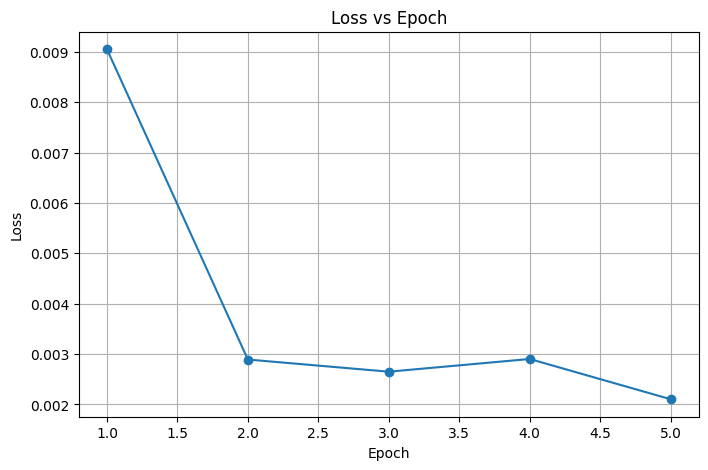

Training complete! Model saved.


In [33]:
# Run training
loss_vs_epoch = train()

In [34]:
loss_vs_epoch

[(1, 0.0090498945899579),
 (2, 0.0028919131500709768),
 (3, 0.002650675990658889),
 (4, 0.002902785695575571),
 (5, 0.002104354406037601)]

### Run 1 - [Batch 40 | Epoch 10]

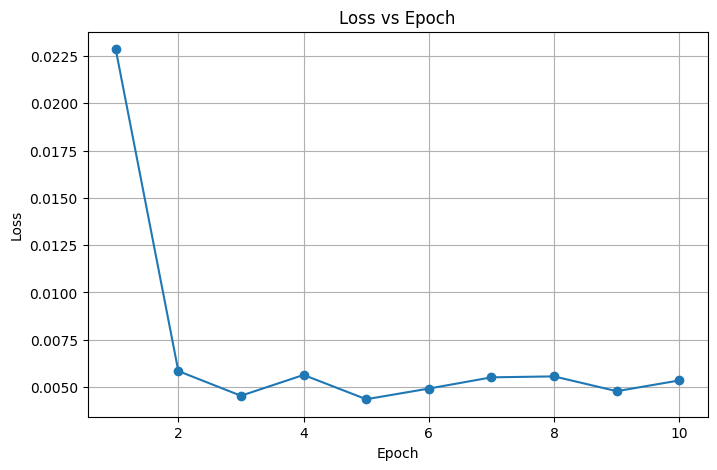

Training complete! Model saved.


In [27]:
# Run training
loss_vs_epoch = train()

In [28]:
loss_vs_epoch

[(1, 0.022859441805054496),
 (2, 0.005845001705999043),
 (3, 0.004538918910203366),
 (4, 0.005639787319806309),
 (5, 0.004356123191684267),
 (6, 0.004919219566836899),
 (7, 0.0055128866028875895),
 (8, 0.00556314397785243),
 (9, 0.0047816884370087825),
 (10, 0.005349772091877525)]

### Run 2 - [Batch 50 | Epoch 30]

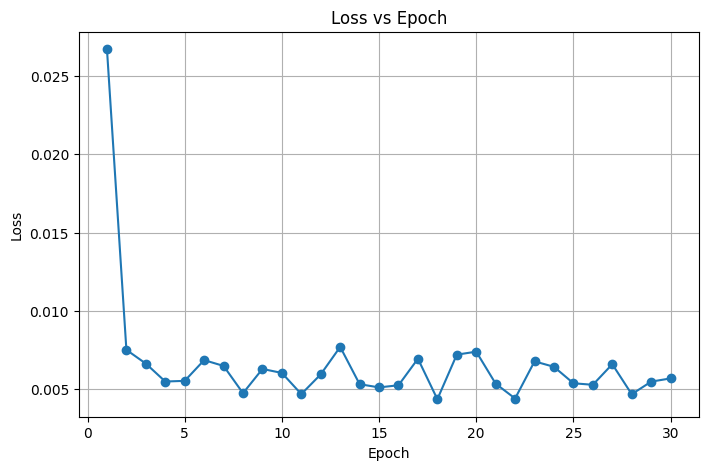

Training complete! Model saved.


In [27]:
# Run training
loss_vs_epoch = train()

In [28]:
loss_vs_epoch

[(1, 0.0267098242723891),
 (2, 0.007515279389212303),
 (3, 0.006637704021396172),
 (4, 0.005493463958599463),
 (5, 0.005535539577249437),
 (6, 0.006859620370739845),
 (7, 0.0064892520043279295),
 (8, 0.004748939495501955),
 (9, 0.006295768769853043),
 (10, 0.00604167666381479),
 (11, 0.004688988093491361),
 (12, 0.00595151035795976),
 (13, 0.00770427146609026),
 (14, 0.005322852207940411),
 (15, 0.005117780296484742),
 (16, 0.0052542209251304015),
 (17, 0.0069493167456874455),
 (18, 0.0043633150219014195),
 (19, 0.00720926541817431),
 (20, 0.007398903006899425),
 (21, 0.005354750515173443),
 (22, 0.004409130824779188),
 (23, 0.006780491320938436),
 (24, 0.006431819756769321),
 (25, 0.005381242053364545),
 (26, 0.005284894624315767),
 (27, 0.006599045243064845),
 (28, 0.004683187873645996),
 (29, 0.005486487318712259),
 (30, 0.005692805146540966)]

# Evaluation

In [29]:
# Load tokenizer
tokenizer_rule = AutoTokenizer.from_pretrained(RULE_MODEL_NAME)  # e.g., rule tokenizer
tokenizer_cti = AutoTokenizer.from_pretrained(CTI_MODEL_NAME)  # e.g., cti tokenizer

# Load model
model = DualEncoderModel(RULE_MODEL_NAME, CTI_MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
# model.eval()

<All keys matched successfully>

In [30]:
tokenized_yaras = tokenizer_rule(yaras, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)
tokenized_ctis = tokenizer_cti(ctis, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)

In [31]:
tokenized_yaras['input_ids'].shape, tokenized_yaras['attention_mask'].shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [32]:
input_ids_yaras = tokenized_yaras["input_ids"].to(DEVICE)
attention_mask_yaras = tokenized_yaras["attention_mask"].to(DEVICE)
input_ids_ctis = tokenized_ctis["input_ids"].to(DEVICE)
attention_mask_ctis = tokenized_ctis["attention_mask"].to(DEVICE)   

In [33]:
emb_yaras, emb_ctis = model(input_ids_yaras, attention_mask_yaras, input_ids_ctis, attention_mask_ctis)

In [34]:
emb_yaras.shape, emb_ctis.shape

(torch.Size([10, 768]), torch.Size([10, 768]))

In [35]:
# Step 2: Compute dot product matrix [num_desc x num_rules]
dot_product_matrix = torch.matmul(emb_ctis, emb_yaras.T)

# Step 3: Apply softmax along rules axis (dim=1), to get attention weights from each description to all rules
attention_weights = F.softmax(dot_product_matrix, dim=1).detach().cpu().numpy()

# Plot Attention

### Run 0 [Batch 16 | Epoch 5]

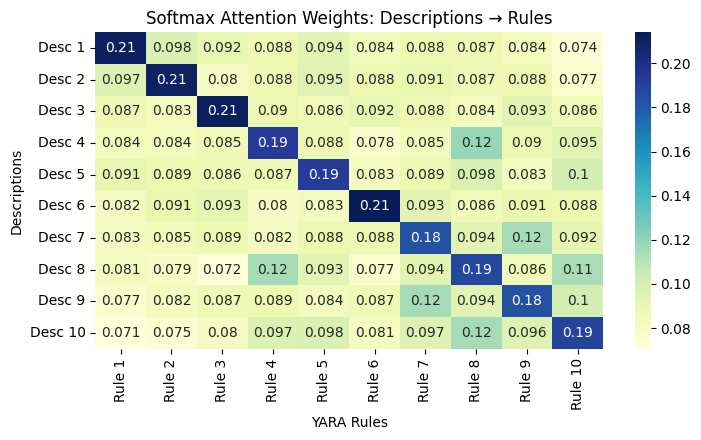

In [42]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 1 - [Batch 40 | Epoch 10]

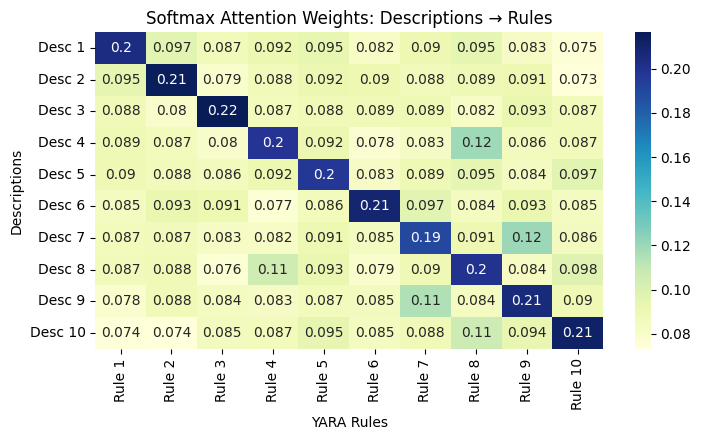

In [36]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 2 - [Batch 50 | Epoch 30]

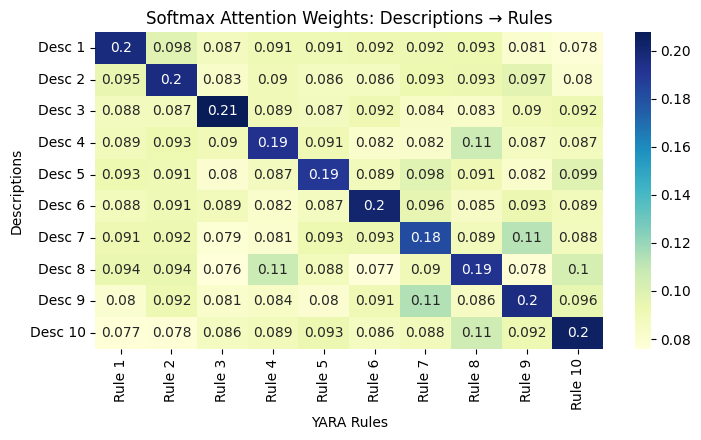

In [36]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()